# Nino3.4 and California DJF precip correlation: emergent constraint in CMIP6? 
### from Allen & Luptowitz (2017) DOI: 10.1038/ncomms16055

Allen and Luptowitz found that CMIP5 models with a high correlation (r > 0.3) between Nino3.4 and DJF precipitation over California show larger increases in California DJF precipitation in the future compared to models with a lower correlation (r < 0.3) between Nino3.4 and CA precipitation

<img src="../Allen_Luptowitz_Fig2.jpg">

In [42]:
# python libraries needed to use functions masking california precip
#!pip install geopandas
#!pip install -u regionmask

In [43]:
# Loading libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
import dask

In [44]:
# load functions from external python scripts
import season_util as su
import jetlatcalcs as jlat
import mask

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
import intake

## Find ts and pr data 
We need temperature ("ts") from the historical experiment to calculate Nino 3.4 indices, and precipitation ("pr") from historical and future experiments

Steps: 
1. Find all available runs for historical ts, historical pr and future pr using intake-esm
2. Find source_id-member_id combinations available across all desired variables/experiments (this is done using inner joins between the data tables)
3. Subset original catalogs to match the source_id-member_id combinations

In [47]:
## col is short for "collection"
## cat is short for "catalog"
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")
ts_cat = col.search(activity_id="CMIP",experiment_id="historical", variable_id="ts", 
                    table_id="Amon")

In [48]:
pr_cat = col.search(activity_id="CMIP",experiment_id="historical", variable_id="pr", 
                    table_id="Amon")

In [49]:
fut_mip = "ScenarioMIP"
fut_exp = "ssp370"
fut_cat = col.search(activity_id=fut_mip,experiment_id=fut_exp, variable_id="pr",
                     table_id="Amon")

In [50]:
overlap_df = pd.merge(ts_cat.df[['source_id', 'member_id']].drop_duplicates(), pr_cat.df[['source_id', 'member_id']].drop_duplicates(), 
              on = ['source_id', 'member_id'], how = "inner")
overlap_df = pd.merge(overlap_df, fut_cat.df[['source_id', 'member_id']].drop_duplicates(), 
              on = ['source_id', 'member_id'], how = "inner")

**NOTE**: some model times are giving errors (CESM2-WACCM ssp370), (EC-Earth3 ssp370). It seems like there might be too many or inconsistent time steps. The problem occurs when subsetting to a time slice, but there don't seem to be any errors calculating seasonal means
--> remove for now

In [51]:
## WACCM time currently not working...
overlap_df = overlap_df[overlap_df.source_id != "CESM2-WACCM"]
overlap_df = overlap_df[overlap_df.source_id != "EC-Earth3"]
## EC-Earth3-Veg has NaNs in CA DJF precip time series...
overlap_df = overlap_df[overlap_df.source_id != "EC-Earth3-Veg"]

In [52]:
ts_cat.df = pd.merge(ts_cat.df, overlap_df, on = ['source_id', 'member_id'], how = "right")
pr_cat.df = pd.merge(pr_cat.df, overlap_df, on = ['source_id', 'member_id'], how = "right")
fut_cat.df = pd.merge(fut_cat.df, overlap_df, on = ['source_id', 'member_id'], how = "right")

#### Load ts data:

In [53]:
dset_dict_hist_ts = ts_cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 11 group(s)


In [54]:
dset_dict_hist_ts.keys()

dict_keys(['CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn', 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn', 'CMIP.CCCma.CanESM5.historical.Amon.gn', 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Amon.gr', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Amon.gr', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr', 'CMIP.MIROC.MIROC6.historical.Amon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn', 'CMIP.NCAR.CESM2.historical.Amon.gn', 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1'])

#### Load pr data (historical and future):

In [55]:
dset_dict_hist = pr_cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 11 group(s)


In [56]:
dset_dict_fut = fut_cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 11 group(s)


## Calculate correlation between Nino3.4 and DJF precip over California

Steps: 
1. Subset ts and pr data to 1948-2014 time period 
2. Calculate time series of DJF average Nino3.4 for each simulation
3. Calculate time series of DJF precipitatin over California for each simulation
4. Detrend both time series 
5. Calculate interannual correlation between Nino3.4 and CA precip for each simulation
6. Calculate average correlation across ensembles for each model

#### Calculate Nino3.4 time series:

In [57]:
corr_tslice = slice('1948-01-01','2015-01-01')
hist_ts = {}
for key, ds in dset_dict_hist_ts.items():
    #print(key)
    hist_ts[key] = ds.sel(time = corr_tslice)

In [58]:
from nino34 import nino34

In [59]:
# usage: nino = nino34(da,'ts','DJF')
hist_nino = {}
for key in hist_ts:
    # calculate index
    hist_nino[key] = nino34(hist_ts[key], 'ts', 'DJF')
    ## add days per month weighting in DJF calc

#### Calculate DJF precip time series for California:

In [60]:
hist = {}
for key, ds in dset_dict_hist.items():
    hist[key] = ds.sel(time = corr_tslice)

In [61]:
hist_ca_pr = {}
for key in hist:
    ca_mask = mask.state_mask(mask.read_state("../data/states.shp", 'California'), 
                              hist[key], 'California', 'CA')
    hist_ca_pr[key] = su.season_ts((hist[key].where(ca_mask == 1)), 
                                   "pr", "DJF").mean(dim=('lat', 'lon'))
## add days per month weighting and areacella weighting

#### Detrend Nino3.4 and CA DJF precip timeseries

In [62]:
from scipy import signal

In [63]:
## compute for use in signal.detrend()
hist_ca_pr = dask.compute(hist_ca_pr)
hist_nino = dask.compute(hist_nino)

In [64]:
nino_dtr = {}
for key in hist_nino[0]:
    #print(key)
    nino_dtr[key] = xr.apply_ufunc(signal.detrend,
                            hist_nino[0][key][:,1:])

In [65]:
ca_pr_dtr = {}
for key in hist_ca_pr[0].keys():
    print(key)
    ca_pr_dtr[key] = xr.apply_ufunc(signal.detrend,
                            hist_ca_pr[0][key][:,1:])

CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Amon.gr
CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Amon.gr
CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr
CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn
CMIP.NCAR.CESM2.historical.Amon.gn
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1


#### Plot of example detrended timeseries
**NOTE:** time series resulting from signal.detrend has mean of 0

Text(0.5, 1.0, 'California DJF precipitation time series')

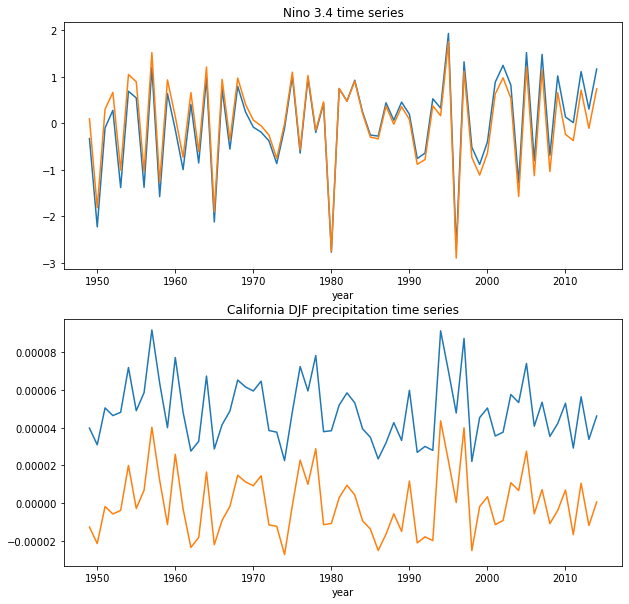

In [66]:
key = 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn'
fig, axes = plt.subplots(nrows = 2, figsize = [10, 10])

hist_nino[0][key][:1,1:].plot(ax = axes[0])
nino_dtr[key][:1,0:].plot(ax = axes[0])
axes[0].set_title("Nino 3.4 time series")

hist_ca_pr[0][key][:1,1:].plot(ax = axes[1]) 
ca_pr_dtr[key][:1,0:].plot(ax = axes[1])
axes[1].set_title("California DJF precipitation time series")

#### Calculate interannual correlation between Nino3.4 and CA DJF precip:

In [67]:
from scipy.stats import pearsonr

In [68]:
hist_cor = {}
for key in nino_dtr.keys():
    print(key)
    hist_cor[key], _ = xr.apply_ufunc(pearsonr, 
                                   nino_dtr[key], 
                                   ca_pr_dtr[key], 
                                  input_core_dims = [['year'], ['year']], 
                                  output_core_dims = [[],[]], 
                                    vectorize = True)

CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Amon.gr
CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Amon.gr
CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr
CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn
CMIP.NCAR.CESM2.historical.Amon.gn
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1


#### Calculate mean correlation across ensembles members within each model:

In [69]:
for key in hist_cor.keys():
    hist_cor[key] = hist_cor[key].mean()

hist_cor

{'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn': <xarray.DataArray ()>
 array(0.35853927),
 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn': <xarray.DataArray ()>
 array(0.27522611),
 'CMIP.CCCma.CanESM5.historical.Amon.gn': <xarray.DataArray ()>
 array(0.17134894),
 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Amon.gr': <xarray.DataArray ()>
 array(-0.18047858),
 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Amon.gr': <xarray.DataArray ()>
 array(-0.14054903),
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr': <xarray.DataArray ()>
 array(0.24257296),
 'CMIP.MIROC.MIROC6.historical.Amon.gn': <xarray.DataArray ()>
 array(0.45103176),
 'CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn': <xarray.DataArray ()>
 array(0.22262018),
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn': <xarray.DataArray ()>
 array(0.37652723),
 'CMIP.NCAR.CESM2.historical.Amon.gn': <xarray.DataArray ()>
 array(0.26096618),
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1': <xarray.DataArray ()>
 array(0.19036158)}

#### Plot of mean correlation in each model 

## Calculate mean DJF precip in historical and future periods: 

Now we want to test whether the emergent constraint exists in CMIP6: is the strength of the correlation between Nino3.4 and CA DJF precip indicative of future changes in CA DJF precip? 

1. Calculate mean DJF precip over historical (1979-2006) and future (2070-2099) time slices in each model (on a grid cell basis)
2. Split models into HIGH-r and LOW-r groups
3. Plot composite maps showing change in DJF precip (future - historical) for the HIGH-r and LOW-r groups

In [70]:
hist_mean = {}
for key, ds in dset_dict_hist.items():
    hist_mean[key] = su.season_mean(ds.sel(time = slice('1979-01-01','2006-01-01')),
                                       var="pr", season="DJF").mean(dim=('member_id'))
    
fut_mean = {}
for key, ds in dset_dict_fut.items():
    #print(key)
    fut_mean[key] = su.season_mean(ds.sel(time = slice('2070-01-01','2099-01-01')),
                                      var="pr", season="DJF").mean(dim=('member_id'))



#### Separate models into high-r and low-r groups

Allen and Luptowitz (2017) use a correlation value of 0.3 to separate models into HIGH-r and LOW-r groups.  

In [71]:
highr_change = {}
lowr_change = {}

for key1, key2, i in zip(fut_mean, hist_mean, range(16)): 
    if(hist_cor[key2] < 0.3):
        lowr_change[key2] = fut_mean[key1] - hist_mean[key2]
    else: 
        highr_change[key2] = fut_mean[key1] - hist_mean[key2]

In [72]:
lowr = None
for key in lowr_change.keys():
    if(lowr is None):
        lowr = lowr_change[key]
    else:
        lowr = xr.concat([lowr, lowr_change[key]], dim = "model")

lowr = lowr.mean(dim=('model'))
          
highr = None
for key in highr_change.keys():
    if(highr is None):
        highr = highr_change[key]
    else:
        highr = xr.concat([highr, highr_change[key]], dim = "model")  

highr = highr.mean(dim=('model'))

### Plot future precip change across HIGH-r and LOW-r groups

Text(0.5, 1.0, 'LOW-r DJF precip change')

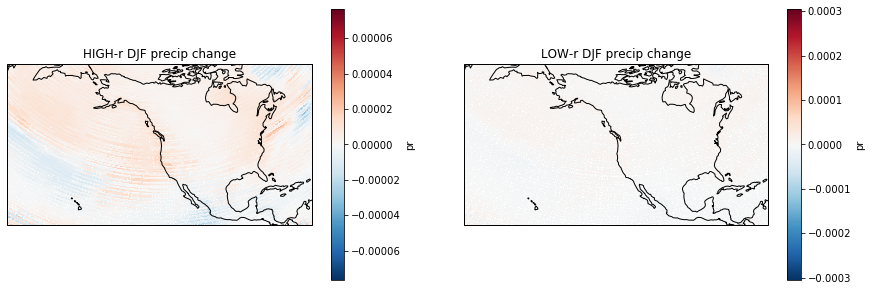

In [80]:
# load cartopy
import cartopy.crs as ccrs
extent = [-180, -70, 10, 70]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
s = (highr).plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree())
ax1.set_extent(extent)
ax1.coastlines()
ax1.set_title("HIGH-r DJF precip change")

ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
s2 = (lowr).plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree())
ax2.set_extent(extent)
ax2.coastlines()
ax2.set_title("LOW-r DJF precip change")   

### Plot future precip change for individual models
2070-2099 precip minus 1979-2005 precip

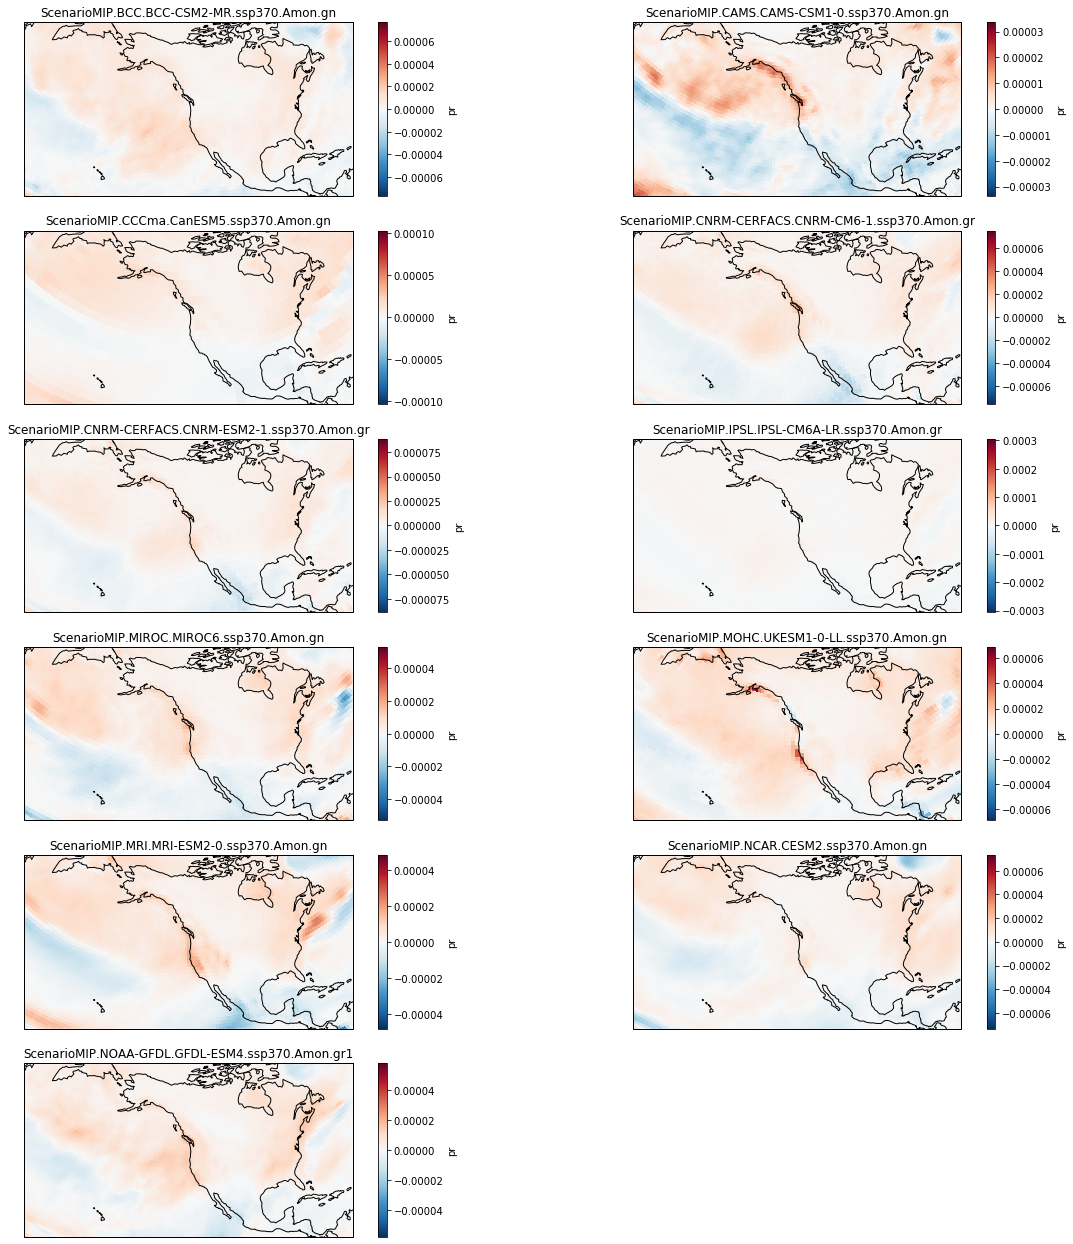

In [79]:
extent = [-180, -70, 10, 70]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig = plt.figure(figsize=(20, 30))
for key1, key2, i in zip(fut_mean, hist_mean, range(16)): 
    ax = fig.add_subplot(8, 2, (i+1), projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    s = (fut_mean[key1] - hist_mean[key2]).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())
    ax.set_extent(extent)
    ax.coastlines()
    ax.set_title(key1)
